#### Import libraries and packages

In [263]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import shapely
import ee, geemap, eemont
import json
import wxee

In [198]:
ee.Authenticate()
ee.Initialize()

#### Load satellite dataset and fire preimeter

Copernicus Sentinel-2 (COPERNICUS/S2_SR_HARMONIZED) data involves using the surface reflectance information in the data to calculate spectral indices like the Normalized Burn Ratio (NBR) or specialized indices like BADI, or employing machine learning algorithms with spectral and textural features to distinguish burned areas from other land cover changes.



data source: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/explore?location=37.187645%2C-120.227660%2C5.95

tutorials: https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine

In [ ]:
%cd pc

In [202]:
in_file = f"data/California_Historic_Fire_Perimeters.geojson"
fire_gdf = gpd.read_file(in_file)

In [203]:
fire_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      22810 non-null  int32   
 1   YEAR_         22733 non-null  float64 
 2   STATE         22810 non-null  object  
 3   AGENCY        22761 non-null  object  
 4   UNIT_ID       22749 non-null  object  
 5   FIRE_NAME     22748 non-null  object  
 6   INC_NUM       21839 non-null  object  
 7   ALARM_DATE    17414 non-null  object  
 8   CONT_DATE     10180 non-null  object  
 9   CAUSE         22810 non-null  int32   
 10  C_METHOD      10708 non-null  float64 
 11  OBJECTIVE     22539 non-null  float64 
 12  GIS_ACRES     22810 non-null  float64 
 13  COMMENTS      2835 non-null   object  
 14  COMPLEX_NAME  611 non-null    object  
 15  IRWINID       3736 non-null   object  
 16  FIRE_NUM      17642 non-null  object  
 17  COMPLEX_ID    567 non-null    object  
 18

In [204]:
fire_gdf.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198..."
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009..."
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,7.0,1.0,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585..."
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,2.0,1.0,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16..."
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,7.0,1.0,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3..."


The dataset includes the year of fires, the occurance place, fire name, alarm and containment date



We chose the fires that occured during 2020-2025, perform statistical analysis to find the time window within each year

Prepare the ground truth for fire area detection on the satellite imagery, by comparing the pre and post fire (before the time window and after the window)

2020
2021
2022
2023
2024
2025

In [205]:
fire_df = pd.DataFrame(fire_gdf)
fire_df["ALARM_DATE_NEW"] = pd.to_datetime(fire_df.ALARM_DATE, format='%a, %d %b %Y %H:%M:%S %Z')
fire_df["CONT_DATE_NEW"] = pd.to_datetime(fire_df.CONT_DATE, format='%a, %d %b %Y %H:%M:%S %Z')

In [206]:
fire_df.head(10)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry,ALARM_DATE_NEW,CONT_DATE_NEW
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198...",2025-01-07 08:00:00+00:00,2025-01-31 08:00:00+00:00
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009...",2025-01-08 08:00:00+00:00,2025-01-31 08:00:00+00:00
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,...,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585...",2025-01-22 08:00:00+00:00,2025-01-28 08:00:00+00:00
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,...,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16...",2025-01-09 08:00:00+00:00,2025-02-04 08:00:00+00:00
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,...,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3...",2025-01-07 08:00:00+00:00,2025-01-09 08:00:00+00:00
5,6,2025.0,CA,CDF,LAC,LIDIA,00010648,"Wed, 08 Jan 2025 08:00:00 GMT","Sat, 11 Jan 2025 08:00:00 GMT",14,...,347.7042,None,None,{E451AEAE-4177-4B78-BDE8-1E27B9D5D56C},None,None,2020-January 2025,"POLYGON ((-118.25563 34.43419, -118.25547 34.4...",2025-01-08 08:00:00+00:00,2025-01-11 08:00:00+00:00
6,7,2024.0,CA,CDF,BTU,PARK,00013761,"Wed, 24 Jul 2024 07:00:00 GMT","Sat, 07 Sep 2024 07:00:00 GMT",7,...,429602.8000,None,None,{22CAD814-48B1-4460-A368-F50F493F3740},None,None,2020-January 2025,"MULTIPOLYGON (((-121.98958 40.06438, -121.9892...",2024-07-24 07:00:00+00:00,2024-09-07 07:00:00+00:00
7,8,2024.0,CA,USF,SQF,BOREL,00001362,"Wed, 24 Jul 2024 07:00:00 GMT","Sun, 15 Sep 2024 07:00:00 GMT",14,...,59288.5400,3 miles SW of Lake Isabella,None,{4CB2F74D-51F9-47E3-8CFA-43F75DCB8A26},None,None,2020-January 2025,"POLYGON ((-118.59852 35.4748, -118.59855 35.47...",2024-07-24 07:00:00+00:00,2024-09-15 07:00:00+00:00
8,9,2024.0,CA,USF,ANF,BRIDGE,00243334,"Sun, 08 Sep 2024 07:00:00 GMT","Tue, 31 Dec 2024 08:00:00 GMT",14,...,55724.1700,Clipped out Fork incident based on severity vi...,None,{928C4DA9-5AD6-4E0C-A3A4-2C36FFEF7223},None,None,2020-January 2025,"MULTIPOLYGON (((-117.64702 34.38097, -117.6470...",2024-09-08 07:00:00+00:00,2024-12-31 08:00:00+00:00
9,10,2024.0,CA,USF,BDF,LINE,00012520,"Fri, 06 Sep 2024 07:00:00 GMT","Mon, 23 Dec 2024 08:00:00 GMT",14,...,43975.6100,"Baseline St x Aplin St, north of City of Highland",None,{4A605BD7-E9EC-42A7-8A86-3BC47A795382},None,None,2020-January 2025,"MULTIPOLYGON (((-116.97606 34.21498, -116.9760...",2024-09-06 07:00:00+00:00,2024-12-23 08:00:00+00:00


<AxesSubplot: >

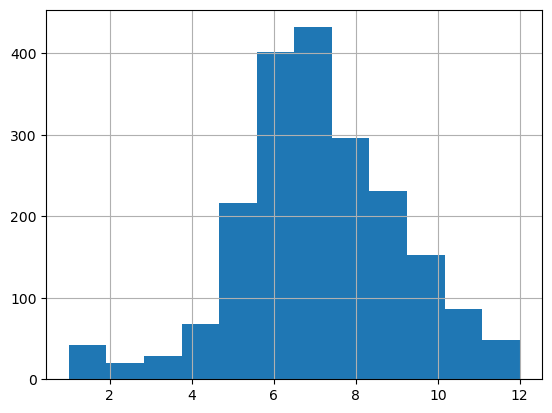

In [233]:
fire_df.query("DECADES == '2020-January 2025'").CONT_DATE_NEW.dt.month.hist(bins=12)

<AxesSubplot: >

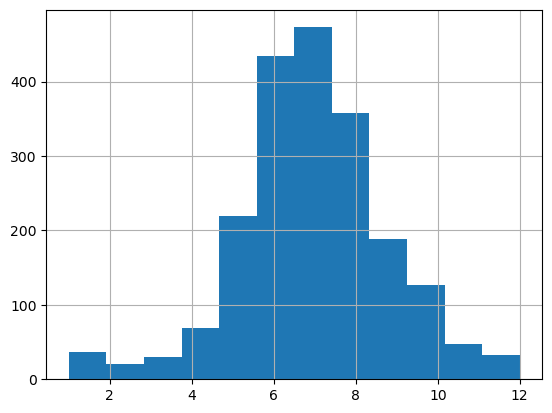

In [234]:
fire_df.query("DECADES == '2020-January 2025'").ALARM_DATE_NEW.dt.month.hist(bins=12)

#### Select study area, time frame and create cloud mask

In [96]:
fire_gdf.DECADES.unique()

array(['2020-January 2025', '2010-2019', '2000-2009', '1990-1999',
       '1980-1989', '1970-1979', '1960-1969', '1950-1959', None],
      dtype=object)

In [175]:
aoi = fire_gdf[fire_gdf.DECADES == "2020-January 2025"]

In [300]:
aoi = fire_df[fire_df.ALARM_DATE_NEW.dt.year == (2025.0 ) ]
aoi = gpd.GeoDataFrame(aoi)

In [301]:
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   OBJECTID        6 non-null      int32              
 1   YEAR_           6 non-null      float64            
 2   STATE           6 non-null      object             
 3   AGENCY          6 non-null      object             
 4   UNIT_ID         6 non-null      object             
 5   FIRE_NAME       6 non-null      object             
 6   INC_NUM         6 non-null      object             
 7   ALARM_DATE      6 non-null      object             
 8   CONT_DATE       6 non-null      object             
 9   CAUSE           6 non-null      int32              
 10  C_METHOD        6 non-null      float64            
 11  OBJECTIVE       6 non-null      float64            
 12  GIS_ACRES       6 non-null      float64            
 13  COMMENTS        1 non-null      obje

In [302]:
js = json.loads(aoi.geometry.to_json())

<AxesSubplot: >

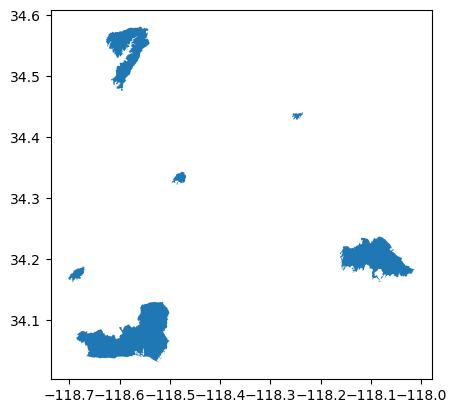

In [303]:
aoi.geometry.plot()

In [304]:
bounds = geemap.geopandas_to_ee(aoi)

In [272]:
AOI = ee.Geometry.BBoxFromQuery("California, USA", user_agent="RS_course")

In [273]:
Map = geemap.Map()
Map.addLayer(AOI)
Map.centerObject(AOI, 10)
Map

Map(center=[37.20748672023382, -119.30639230000027], controls=(WidgetControl(options=['position', 'transparent…

In [305]:
pre_dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterDate("2024-12-01", "2025-01-01")
    .filterBounds(bounds)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
)

In [306]:
post_dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR')
    .filterDate("2025-01-01", "2025-03-01")
    .filterBounds(AOI)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
)

In [307]:
pre_dataset_ts = pre_dataset.select(['B8', 'B12']).wx.to_time_series()
post_dataset_ts = post_dataset.select(['B8', 'B12']).wx.to_time_series()

In [253]:
pre_dataset_ts.timeline()

In [308]:
pre_dataset_ts.describe()

COPERNICUS/S2_SR
	Images: 2
	Start date: 2024-12-18 18:45:00 UTC
	End date: 2024-12-18 18:45:03 UTC
	Mean interval: 0.00 days


In [309]:
post_dataset_ts.describe()

COPERNICUS/S2_SR
	Images: 1,287
	Start date: 2025-01-01 18:24:55 UTC
	End date: 2025-02-28 19:23:18 UTC
	Mean interval: 0.05 days
